<a href="https://colab.research.google.com/github/Esther-Wagatwe/EASY-ML/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of transfert learning with CIFAR-10 dataset and the model VGG16 trained on ImageNet database

In [ ]:
# Import librairies
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

## Preparation of CIFAR-10 dataset

In [ ]:
# Define a sequence of transforms to convert the image to a PyTorch tensor and normalize it.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [ ]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)# DataLoader for batching and shuffling

# Define the number of images for the subset
subset_size = 300
all_indices = torch.randperm(len(train_dataset))  # mixed indices
train_indices = all_indices[:subset_size]     # keep only subset_size
test_indices = torch.randperm(len(test_dataset))[:150] # just half of the images for the test

# Keep a small subset of the dataset
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

BATCH_SIZE = 64 # Define the number of samples per batch

# Turn datasets into iterables (batches)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Display the name of the 10 classes
train_dataset.classes

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

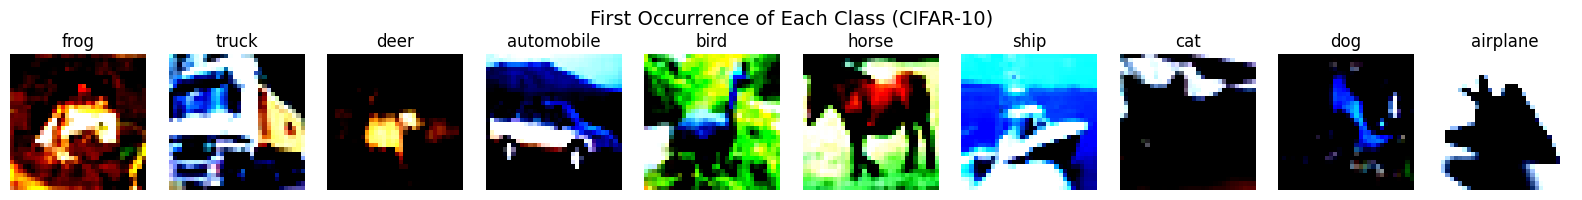

In [ ]:
# Visualization of the 10 class
fig, axs = plt.subplots(1, 10, figsize=(16, 2))
fig.suptitle("First Occurrence of Each Class (CIFAR-10)", fontsize=14)

seen_classes = set()
shown = 0

for img_disp, lbl in train_dataset:
    if lbl not in seen_classes:
        #img_disp = unnormalize(img)  # undo normalization if needed
        img_disp = img_disp.permute(1, 2, 0).clamp(0, 1).numpy()  # CxHxW -> HxWxC
        axs[shown].imshow(img_disp)
        axs[shown].set_title(train_dataset.classes[lbl])
        axs[shown].axis("off")
        seen_classes.add(lbl)
        shown += 1
    if shown == 10:
        break

plt.tight_layout()
plt.show()

## Load and modify the pre-trained VGG16 model

In [ ]:
# Load pre-trained VGG16 model with trained model weights on ImageNet
# available weights are listed on the PyTorch website
# https://docs.pytorch.org/vision/stable/models.html

model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

# Display the structure of the model
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We need to modify the last layer so that it corresponds to the number of classes in our task, i.e. 10 classes on CIFAR-10 (compared with 1,000 classes for the model pre-trained on ImageNet). The structure of the model is described in the print. We can see that the last layer is #6 of the `classifier`.

In [ ]:
# Modify the classifier for CIFAR-10 (10 classes)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layers of the classifier to adapt their weight during training
for param in model.classifier.parameters():
    param.requires_grad = True

# Train the model

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) # Small learning rate

# Training loop
epochs = 5
for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed sample

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 2.2937, Accuracy: 29.33%
Epoch [2/5], Loss: 1.4719, Accuracy: 63.00%
Epoch [3/5], Loss: 1.5014, Accuracy: 66.67%
Epoch [4/5], Loss: 1.6162, Accuracy: 71.33%
Epoch [5/5], Loss: 0.9509, Accuracy: 83.33%


# Evaluate the model

In [ ]:
# Evaluate the Model

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 44.67%


# Training from scratch
For comparison, we can try training the same dataset on the model from scratch, i.e. without retrieving the trained weights from ImageNet.

In [ ]:
# Load the model without the weights
model_from_scratch = torchvision.models.vgg16(weights=None)

# Modify the classifier for CIFAR-10 (10 classes)
model_from_scratch.classifier[6] = nn.Linear(in_features=4096, out_features=10)

# Move model on device
model_from_scratch = model_from_scratch.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_from_scratch.classifier.parameters(), lr=0.001) # Small learning rate

# Training loop
epochs = 5
for epoch in range(epochs):
    # Set the model to training mode
    model_from_scratch.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed sample

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model
model_from_scratch.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 4.1579, Accuracy: 10.00%
Epoch [2/5], Loss: 2.3589, Accuracy: 10.67%
Epoch [3/5], Loss: 2.2743, Accuracy: 16.00%
Epoch [4/5], Loss: 2.3328, Accuracy: 10.33%
Epoch [5/5], Loss: 2.2853, Accuracy: 9.33%
Test Accuracy: 14.00%


# Hands-on practice
By groupe, work on the fruits dataset you created earlier and train it from learning transfer. You can test other models if you wish, or include data augmentation.

In [ ]:
# Loading data from my Google drive
from google.colab import drive
drive.mount('/content/drive')



In [ ]:
# Unzip file
!unzip /content/drive/MyDrive/Easy_ML/fruits_data.zip -d fruits_data

Archive:  /content/drive/MyDrive/Easy_ML/fruits_data.zip
   creating: fruits_data/apples/
  inflating: fruits_data/apples/Apples93.png  
  inflating: fruits_data/apples/Apples38.png  
  inflating: fruits_data/apples/Apples94.png  
  inflating: fruits_data/apples/Apples95.png  
  inflating: fruits_data/apples/Apples159.png  
  inflating: fruits_data/apples/Apples96.png  
  inflating: fruits_data/apples/Apples117.png  
  inflating: fruits_data/apples/Apples97.png  
  inflating: fruits_data/apples/Apples116.png  
  inflating: fruits_data/apples/Apples99.png  
  inflating: fruits_data/apples/Apples102.png  
  inflating: fruits_data/apples/Apples98.png  
  inflating: fruits_data/apples/Apples105.png  
  inflating: fruits_data/apples/Apples100.png  
  inflating: fruits_data/apples/Apples160.png  
  inflating: fruits_data/apples/Apples161.png  
  inflating: fruits_data/apples/Apples101.png  
  inflating: fruits_data/apples/Apples103.png  
  inflating: fruits_data/apples/Apples5.png  
  inflat

In [ ]:
# ! rm -rf /content/apples # To delete folder

In [ ]:
import os

data_dir = '/content/fruits_data'
class_folder = os.listdir(data_dir)
num_classes = len(class_folder)
num_classes

2

In [ ]:
# PREPARE DATASET
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ful_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


train_dataset = int(0.8 * len(ful_dataset))
test_dataset = len(ful_dataset) - train_dataset

train_set, test_set = torch.utils.data.random_split(ful_dataset, [train_dataset, test_dataset])

print(len(train_set))
print(len(test_set))

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

250
63


In [ ]:
# Number of images in the folder
! ls /content/fruits_data/apples | wc -l

161


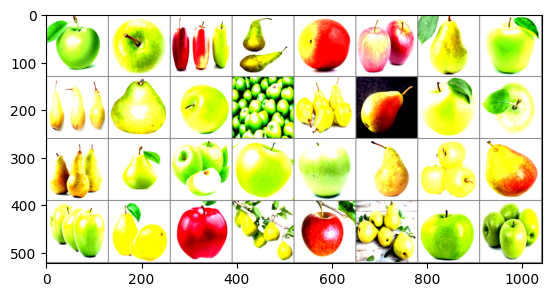

apples apples apples Pears apples apples Pears apples Pears Pears apples apples Pears Pears apples apples Pears Pears apples apples apples Pears apples Pears apples Pears apples Pears apples Pears apples apples


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{ful_dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# load pretrained VGG16 model
import torchvision

model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# modify classifier on fruit dataset with 2 classes

model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

#freeze initial layers
for param in model.parameters():
  param.requires_grad = False

#unfreeze layers of the classifier to adapt to the weight during training
for param in model.classifier.parameters():
  param.requires_grad = True

In [ ]:
# training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


# Training loop
epochs = 10
for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed samples

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 0.0365, Accuracy: 99.20%
Epoch [2/10], Loss: 0.1295, Accuracy: 98.80%
Epoch [3/10], Loss: 0.4704, Accuracy: 97.60%
Epoch [4/10], Loss: 0.7022, Accuracy: 96.80%
Epoch [5/10], Loss: 0.8268, Accuracy: 97.60%
Epoch [6/10], Loss: 0.4335, Accuracy: 98.00%
Epoch [7/10], Loss: 0.3059, Accuracy: 98.40%
Epoch [8/10], Loss: 0.1831, Accuracy: 99.20%
Epoch [9/10], Loss: 1.1128, Accuracy: 97.60%
Epoch [10/10], Loss: 0.9338, Accuracy: 98.40%


In [ ]:
# Evaluate the model

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 98.41%


# Plot a confusion matrix for the model using the test dataset.

## Get predictions and true labels

### Subtask:
Iterate through the test dataset and collect the model's predictions and the corresponding true labels.


**Reasoning**:
Initialize empty lists and iterate through the test loader to collect true and predicted labels.



In [ ]:
all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().tolist())
        all_predicted.extend(predicted.cpu().tolist())

## Generate confusion matrix

### Subtask:
Use the collected predictions and true labels to generate a confusion matrix.


**Reasoning**:
Use the collected predictions and true labels to generate a confusion matrix.



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predicted)

## Plot confusion matrix

### Subtask:
Visualize the confusion matrix.


**Reasoning**:
Visualize the confusion matrix using a heatmap.



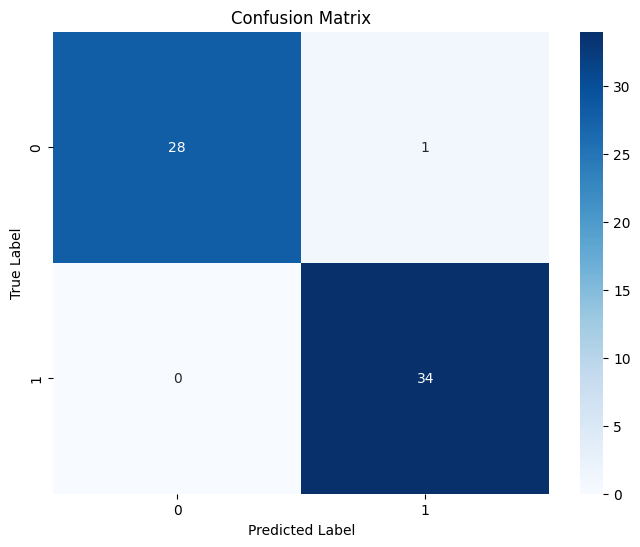

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The true labels and predicted labels were successfully collected from the test dataset.
*   A confusion matrix was successfully generated using the collected true and predicted labels.
*   A heatmap visualization of the confusion matrix was created and displayed, showing the distribution of true positives, true negatives, false positives, and false negatives.

### Insights or Next Steps

*   Analyze the confusion matrix to understand the model's performance for each class, identifying where the model is performing well and where it is making errors.
*   Consider further analysis or model improvements based on the insights gained from the confusion matrix, such as focusing on classes with high false positive or false negative rates.


In [ ]:
# Load the model without the weights
model_from_scratch = torchvision.models.vgg16(weights=None)
model_from_scratch

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Modify the classifier for CIFAR-10 (10 classes)
model_from_scratch.classifier[6] = nn.Linear(in_features=4096, out_features=10)

# Move model on device
model_from_scratch = model_from_scratch.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_from_scratch.classifier.parameters(), lr=0.001) # Small learning rate

# Training loop
epochs = 10
for epoch in range(epochs):
    # Set the model to training mode
    model_from_scratch.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed sample

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model
model_from_scratch.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 1.0990, Accuracy: 43.60%
Epoch [2/10], Loss: 0.8007, Accuracy: 55.20%
Epoch [3/10], Loss: 0.7164, Accuracy: 52.80%
Epoch [4/10], Loss: 0.7065, Accuracy: 57.60%
Epoch [5/10], Loss: 0.6664, Accuracy: 61.20%
Epoch [6/10], Loss: 0.6650, Accuracy: 62.40%
Epoch [7/10], Loss: 0.6689, Accuracy: 63.20%
Epoch [8/10], Loss: 0.6506, Accuracy: 61.60%
Epoch [9/10], Loss: 0.5613, Accuracy: 71.60%
Epoch [10/10], Loss: 0.5508, Accuracy: 71.20%
Test Accuracy: 77.78%
